# Global BGC metrics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client

#import catalog
#import util
import utils
xr.set_options(keep_attrs=True)
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
import numpy as np
import pandas as pd

In [3]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

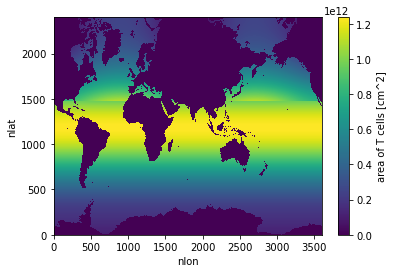

In [4]:
masked_area = area.where(ds_grid.REGION_MASK > 0).fillna(0.) 
masked_area.plot()

### Parameters

In [5]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [6]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [7]:
variables =['photoC_sp_zint','photoC_diat_zint',
            'photoC_diaz_zint','photoC_cocco_zint',
            'SiO2_PROD','CaCO3_PROD_zint','diaz_Nfix',
            'mesozooC','microzooC','x_graze_microzoo_zint','x_graze_mesozoo_zint',
            'POC_FLUX_100m']
cvars = ['photoC_sp_zint','photoC_diat_zint',
         'photoC_diaz_zint','photoC_cocco_zint', 'POC_FLUX_100m',
         'CaCO3_PROD_zint','x_graze_microzoo_zint','x_graze_mesozoo_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [8]:
def preprocess(ds):
    ds=ds.mean(dim='time')
    ds=ds.isel(z_t=slice(0,10))
    return ds

In [9]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [10]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='04:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [11]:
cluster, client = get_ClusterClient()
cluster.scale(20) 
client

Client Scheduler: tcp://128.117.208.109:35663 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Select 1986 to 2005

In [12]:
ds_fosi_x01 = xr.Dataset()

ds_glb = xr.Dataset()

for var in cvars:
    
    ds_var = xr.Dataset()
    print('starting on ', var)

    var_ts = np.zeros([20])
    i = 0
    
    for yr in np.arange(1986,2006,1):
    
        print(yr)

        files = sorted(glob(f'{path}/{case}.pop.h.{var}.{yr}??-{yr}??.nc'))       
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                           drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
                                  #chunks={"nlat": 1200, "nlon": 1200, "time": 1, "z_t": 1, "z_t_150m": 1})

        keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])

        var_ts[i] = (ds_tmp [var] * masked_area).sum(['nlat', 'nlon'])

        i = i + 1
        
    ### for C vars
    ds_glb[var] = xr.DataArray(var_ts,dims=('time'))
    ds_glb[var] = ds_glb[var] * nmols_to_PgCyr        
    ds_glb[var].attrs['units'] = 'Pg C yr$^{-1}$'

starting on  photoC_sp_zint
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  photoC_diat_zint
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  photoC_diaz_zint
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  photoC_cocco_zint
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  POC_FLUX_100m
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  CaCO3_PROD_zint
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  x_graze_microzoo_zint
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  x_graze_mesozoo_zint
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1

In [13]:
ds_glb['photoC_TOT_zint'] = ds_glb.photoC_sp_zint + ds_glb.photoC_diat_zint + ds_glb.photoC_diaz_zint + ds_glb.photoC_cocco_zint

### Percent diatoms

In [14]:
ds_glb['diatNPPpercent'] = ds_glb.photoC_diat_zint / ds_glb.photoC_TOT_zint * 100.
ds_glb['diatNPPpercent'].attrs['units'] = '%'

In [15]:
ds_glb

<xarray.Dataset>
Dimensions:                (time: 20)
Dimensions without coordinates: time
Data variables:
    photoC_sp_zint         (time) float64 28.12 28.1 28.21 ... 28.29 28.21 28.29
    photoC_diat_zint       (time) float64 20.11 19.14 21.28 ... 19.75 19.72 20.1
    photoC_diaz_zint       (time) float64 1.039 1.053 1.032 ... 1.03 1.033 1.023
    photoC_cocco_zint      (time) float64 2.924 2.955 3.114 ... 3.106 3.034
    POC_FLUX_100m          (time) float64 6.392 6.165 6.743 ... 6.35 6.353 6.407
    CaCO3_PROD_zint        (time) float64 0.8447 0.8386 0.9727 ... 0.8829 0.8612
    x_graze_microzoo_zint  (time) float64 8.899 8.902 8.945 ... 8.97 8.958 8.97
    x_graze_mesozoo_zint   (time) float64 4.327 4.16 4.486 ... 4.233 4.258 4.303
    photoC_TOT_zint        (time) float64 52.2 51.25 53.63 ... 52.1 52.06 52.44
    diatNPPpercent         (time) float64 38.53 37.35 39.68 ... 37.87 38.33

### zooplankton biomass

In [16]:
for var in ['microzooC','mesozooC']:
    
    print('starting on ', var)
    var_ts = np.zeros([20])
    i = 0
    
    for yr in np.arange(1986,2006,1):
    
        print(yr)

        files = sorted(glob(f'{path}/{case}.pop.h.{var}.{yr}??-{yr}??.nc'))       
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                           drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
                                  #chunks={"nlat": 1200, "nlon": 1200, "time": 1, "z_t": 1, "z_t_150m": 1})

        keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

        #ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
                              
        ## depth integrate
                              
        ds_tmp[var] = (ds_tmp[var] * 10.).sum(dim='z_t_150m') #mmol/m2

        var_ts[i] = (ds_tmp[var] * area_m * 0.001).sum(dim=('nlon','nlat')) ## mol

        var_ts[i] = var_ts[i] * 1.e-15 * 12.011 #Pg C
        
        i = i + 1
        
    ds_glb[var] = xr.DataArray(var_ts,dims=('time'))
    ds_glb[var].attrs['units'] = 'Pg C'

starting on  microzooC
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
starting on  mesozooC
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005


In [17]:
ds_glb

<xarray.Dataset>
Dimensions:                (time: 20)
Dimensions without coordinates: time
Data variables:
    photoC_sp_zint         (time) float64 28.12 28.1 28.21 ... 28.29 28.21 28.29
    photoC_diat_zint       (time) float64 20.11 19.14 21.28 ... 19.75 19.72 20.1
    photoC_diaz_zint       (time) float64 1.039 1.053 1.032 ... 1.03 1.033 1.023
    photoC_cocco_zint      (time) float64 2.924 2.955 3.114 ... 3.106 3.034
    POC_FLUX_100m          (time) float64 6.392 6.165 6.743 ... 6.35 6.353 6.407
    CaCO3_PROD_zint        (time) float64 0.8447 0.8386 0.9727 ... 0.8829 0.8612
    x_graze_microzoo_zint  (time) float64 8.899 8.902 8.945 ... 8.97 8.958 8.97
    x_graze_mesozoo_zint   (time) float64 4.327 4.16 4.486 ... 4.233 4.258 4.303
    photoC_TOT_zint        (time) float64 52.2 51.25 53.63 ... 52.1 52.06 52.44
    diatNPPpercent         (time) float64 38.53 37.35 39.68 ... 37.87 38.33
    microzooC              (time) float64 0.239 0.2395 0.2379 ... 0.2402 0.2404
    mesozooC               (time) float64 0.3797 0.3728 0.3843 ... 0.3756 0.3764

### silicification

In [30]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [31]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='256GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=256GB',
        project='NCGD0011',
        walltime='04:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [32]:
cluster, client = get_ClusterClient()
cluster.scale(20) 
client

Client Scheduler: tcp://128.117.208.109:38787 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [33]:
var = 'SiO2_PROD'
yr = 1986

files = sorted(glob(f'{path}/{case}.pop.h.{var}.{yr}??-{yr}??.nc'))       
ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                   drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
                          #chunks={"nlat": 1200, "nlon": 1200, "time": 1, "z_t": 1, "z_t_150m": 1})

In [34]:
ds_tmp[var] = (ds_tmp[var] * 10.).sum(dim='z_t') ## depth integral, units in mmol/m2/s
ds_tmp[var] = ds_tmp[var] * area_m ## mmol/s
ds_tmp[var] = ds_tmp[var] * 86400. * 365 * 0.001 ## mol/yr 

In [35]:
test = ds_tmp[var].sum(dim=('nlon','nlat'))

In [36]:
test.values

array(1.02473929e+14)

In [ ]:
var = 'SiO2_PROD'

print('starting on ', var)
var_ts = np.zeros([20])
i = 0

for yr in np.arange(1986,2006,1):
    print(yr)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.{yr}??-{yr}??.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
                              #chunks={"nlat": 1200, "nlon": 1200, "time": 1, "z_t": 1, "z_t_150m": 1})

    ds_tmp[var] = (ds_tmp[var] * 10.).sum(dim='z_t') ## depth integral, units in mmol/m2/s
    ds_tmp[var] = ds_tmp[var] * area_m ## mmol/s
    ds_tmp[var] = ds_tmp[var] * 86400. * 365 * 0.001 ## mol/yr 
    var_ts[i] = ds_tmp[var].sum(dim=('nlon','nlat')).values * 1.e-12 #Tmol/yr
    i = i + 1
    
ds_glb['SiO2_PROD'] = xr.DataArray(var_ts,dims=('time'))
ds_glb['SiO2_PROD'].attrs['units'] = 'Tmol Si yr$^{-1}$'

starting on  SiO2_PROD
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997


### Nitrogen fixation

In [53]:
var = 'diaz_Nfix'

print('starting on ', var)
var_ts = np.zeros([20])
i = 0

for yr in np.arange(1986,2006,1):
    print(yr)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.{yr}??-{yr}??.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
                              #chunks={"nlat": 1200, "nlon": 1200, "time": 1, "z_t": 1, "z_t_150m": 1})

    ds_tmp[var] = (ds_tmp[var] * 10.).sum(dim='z_t_150m') ## depth integral, units in mmol/m2/s
    ds_tmp[var] = ds_tmp[var] * area_m ## mmol/s
    ds_tmp[var] = ds_tmp[var] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
    var_ts[i] = ds_tmp[var].sum(dim=('nlon','nlat')).values

    i = i + 1

ds_glb['diaz_Nfix'] = xr.DataArray(var_ts,dims=('time'))
ds_glb['diaz_Nfix'].attrs['units'] = 'Tg N yr$^{-1}$'

starting on  diaz_Nfix
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005


### Zooplankton productivity as % NPP

In [43]:
ds_glb['zooprodNPPpercent'] = (ds_glb['x_graze_mesozoo_zint'] + ds_glb['x_graze_microzoo_zint'])/ds_glb['photoC_TOT_zint'] * 100.
ds_glb['zooprodNPPpercent'].attrs['units'] = '%'

In [60]:
ds_glb

<xarray.Dataset>
Dimensions:                (time: 20)
Dimensions without coordinates: time
Data variables: (12/15)
    photoC_sp_zint         (time) float64 28.12 28.1 28.21 ... 28.29 28.21 28.29
    photoC_diat_zint       (time) float64 20.11 19.14 21.28 ... 19.75 19.72 20.1
    photoC_diaz_zint       (time) float64 1.039 1.053 1.032 ... 1.03 1.033 1.023
    photoC_cocco_zint      (time) float64 2.924 2.955 3.114 ... 3.106 3.034
    POC_FLUX_100m          (time) float64 6.392 6.165 6.743 ... 6.35 6.353 6.407
    CaCO3_PROD_zint        (time) float64 0.8447 0.8386 0.9727 ... 0.8829 0.8612
    ...                     ...
    diatNPPpercent         (time) float64 38.53 37.35 39.68 ... 37.87 38.33
    microzooC              (time) float64 0.239 0.2395 0.2379 ... 0.2402 0.2404
    mesozooC               (time) float64 0.3797 0.3728 0.3843 ... 0.3756 0.3764
    diaz_Nfix              (time) float64 177.8 180.6 176.1 ... 175.7 173.6
    zooprodNPPpercent      (time) float64 25.34 25.49 25.04 ... 25.38 25.31
    SiO2_PROD              (time) float64 102.5 96.46 108.5 ... 100.5 101.5

In [63]:
ds_glb_mean =  ds_glb.mean(dim='time')

In [64]:
ds_glb_stdev = ds_glb.std(dim='time')

In [65]:
ds_glb_mean

<xarray.Dataset>
Dimensions:                ()
Data variables: (12/15)
    photoC_sp_zint         float64 28.26
    photoC_diat_zint       float64 19.95
    photoC_diaz_zint       float64 1.035
    photoC_cocco_zint      float64 3.023
    POC_FLUX_100m          float64 6.391
    CaCO3_PROD_zint        float64 0.8729
    ...                     ...
    diatNPPpercent         float64 38.16
    microzooC              float64 0.2402
    mesozooC               float64 0.3772
    diaz_Nfix              float64 176.3
    zooprodNPPpercent      float64 25.35
    SiO2_PROD              float64 101.7

In [66]:
ds_glb_stdev

<xarray.Dataset>
Dimensions:                ()
Data variables: (12/15)
    photoC_sp_zint         float64 0.1136
    photoC_diat_zint       float64 0.5323
    photoC_diaz_zint       float64 0.009592
    photoC_cocco_zint      float64 0.05806
    POC_FLUX_100m          float64 0.1328
    CaCO3_PROD_zint        float64 0.02788
    ...                     ...
    diatNPPpercent         float64 0.5934
    microzooC              float64 0.0009314
    mesozooC               float64 0.003968
    diaz_Nfix              float64 2.18
    zooprodNPPpercent      float64 0.1031
    SiO2_PROD              float64 3.051

### Make a table of global metrics

In [49]:
df = pd.DataFrame(columns=['Metric','unit','CESM','Obs','Reference'])

In [67]:
df.loc[0] = ['NPP',ds_glb_mean.photoC_TOT_zint.attrs['units'],np.round(ds_glb_mean.photoC_TOT_zint.values, 2),'45 to 55','Behrenfeld & Falkowski 1997; Carr et al., 2006']
df.loc[1] = ['POC export 100m',ds_glb_mean.POC_FLUX_100m.attrs['units'],np.round(ds_glb_mean.POC_FLUX_100m.values, 2),'4 to 12','DeVries & Weber, 2017']
df.loc[2] = ['%NPP by diatoms',ds_glb_mean.diatNPPpercent.attrs['units'],np.round(ds_glb_mean.diatNPPpercent.values, 2),'40%','Nelson et al., 1995']
df.loc[3] = ['Silicification',ds_glb_mean.SiO2_PROD.attrs['units'],np.round(ds_glb_mean.SiO2_PROD.values, 2),'100 to 190','Nelson et al., 1995; Holzer et al., 2014']
df.loc[4] = ['Calcification',ds_glb_mean.CaCO3_PROD_zint.attrs['units'],np.round(ds_glb_mean.CaCO3_PROD_zint.values, 2),'0.7 to 4.7','Liang et al., 2023; Ziveri et al., 2023 and refs therein']
df.loc[5] = ['Nitrogen fixation',ds_glb_mean.diaz_Nfix.attrs['units'],np.round(ds_glb_mean.diaz_Nfix.values, 2),'125.6 and 222.9','Wang et al., 2019']
df.loc[6] = ['Microzooplankton biomass',ds_glb_mean.microzooC.attrs['units'],np.round(ds_glb_mean.microzooC.values, 2),'0.24','Buitenhuis et al., 2010']
df.loc[7] = ['Mesozooplankton biomass',ds_glb_mean.mesozooC.attrs['units'],np.round(ds_glb_mean.mesozooC.values, 2),'0.16 to 0.19','Buitenhuis et al., 2006; Moriarty & OBrien, 2013']
df.loc[8] = ['Zoo prod % of NPP',ds_glb_mean.zooprodNPPpercent.attrs['units'],np.round(ds_glb_mean.zooprodNPPpercent.values, 2),'at least 21%','Landry and Calbet, 2004']

In [68]:
df

,Metric,unit,CESM,Obs,Reference
0,NPP,Pg C yr$^{-1}$,52.26,45 to 55,"Behrenfeld & Falkowski 1997; Carr et al., 2006"
1,POC export 100m,Pg C yr$^{-1}$,6.39,4 to 12,"DeVries & Weber, 2017"
2,%NPP by diatoms,%,38.16,40%,"Nelson et al., 1995"
3,Silicification,Tmol Si yr$^{-1}$,101.73,100 to 190,"Nelson et al., 1995; Holzer et al., 2014"
4,Calcification,Pg C yr$^{-1}$,0.87,0.7 to 4.7,"Liang et al., 2023; Ziveri et al., 2023 and re..."
5,Nitrogen fixation,Tg N yr$^{-1}$,176.34,125.6 and 222.9,"Wang et al., 2019"
6,Microzooplankton biomass,Pg C,0.24,0.24,"Buitenhuis et al., 2010"
7,Mesozooplankton biomass,Pg C,0.38,0.16 to 0.19,"Buitenhuis et al., 2006; Moriarty & OBrien, 2013"
8,Zoo prod % of NPP,%,25.35,at least 21%,"Landry and Calbet, 2004"


In [36]:
cluster.close()